### SVM代码实现(改进SMO算法实现)

In [1]:
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

In [3]:
#随机选择一个不等于i值的j
def selectJrand(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

In [4]:
#进行剪辑
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

### 定义一个新的数据结构

In [5]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2)))#第一列是标志位，0无效 1有效

### 计算Ei的方法

In [6]:
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

### 选择第二个待优化的alpha j，选择一个误差最大的alpha j

In [7]:
def selectJ(i, oS, Ei):
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #设为有效
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #迭代所有有效的缓存，找到误差最大的E
            if k == i: continue #不选择和i相等的值
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #第一次循环时是没有有效的缓存值得，所以随机选一个(仅会执行一次)
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

### 更新缓存

In [8]:
def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

In [9]:
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #这里不再是随机选取了
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print("L==H"); return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #这里增加了更新缓存的方法
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        updateEk(oS, i) #这里增加了更新缓存的方法
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0


### 完整的改进后的SMO算法

In [10]:
def smoP(dataMatIn, classLabels, C, toler, maxIter):
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #遍历全部数据集
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#遍历非边界数据集
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #进行切换
        elif (alphaPairsChanged == 0): entireSet = True
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas


In [11]:
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
L==H
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
j not moving enough
fullSet, iter: 0 i:7, pairs changed 2
L==H
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
L==H
fullSet, iter: 0 i:10, pairs changed 2
L==H
fullSet, iter: 0 i:11, pairs changed 2
L==H
fullSet, iter: 0 i:12, pairs changed 2
fullSet, iter: 0 i:13, pairs changed 2
L==H
fullSet, iter: 0 i:14, pairs changed 2
fullSet, iter: 0 i:15, pairs changed 2
fullSet, iter: 0 i:16, pairs changed 2
L==H
fullSet, iter: 0 i:17, pairs changed 2
fullSet, iter: 0 i:18, pairs changed 3
fullSet, iter: 0 i:19, pairs changed 3
fullSet, iter: 0 i:20, pairs changed 3
fullSet, iter: 0 i:21, pairs changed 3
j not moving enough
fullSet, iter: 0 i:22, pairs changed 3
L==H
fullSet, iter: 0 i:23, 

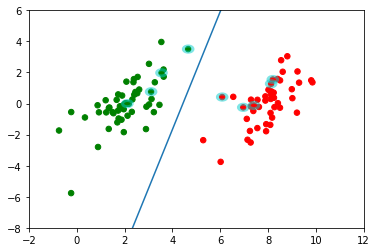

In [12]:
dataMat,labelMat = loadDataSet('data/svm1.txt')
#画图
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)
# plt.show()
###########
b,alphas = smoP(dataMat,labelMat,0.6,0.001,40)
w = calcWs(alphas,dataMat,labelMat)
print('b=',b)
print('alphas=',alphas)
print('w=',w)
#画决策平面
x = arange(-2.0, 12.0, 0.1)
y = (-w[0]*x - b)/w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])

###########
#画支持向量
alphas_non_zeros_index = where(alphas>0)
for i in alphas_non_zeros_index[0]:
    circle = Circle((dataMat[i][0], dataMat[i][1]), 0.2, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
plt.show()